# Get Started in 10 Minutes

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

In this page we will be showing basic capabilities of MDIO.

For demonstration purposes, we will ingest the **remote** Teapot Dome open-source dataset.
The dataset details and licensing can be found at the [SEG Wiki](https://wiki.seg.org/wiki/Teapot_dome_3D_survey).

We are using the 3D seismic stack dataset named `filt_mig.sgy`.

The full HTTP link for the dataset (hosted on AWS): http://s3.amazonaws.com/teapot/filt_mig.sgy

```{warning}
For plotting and remote ingestion the notebook requires [Matplotlib](https://matplotlib.org/) and `aiohttp`
as a dependency. Please install it before executing using `pip install matplotlib aiohttp` or
 `conda install matplotlib aiohttp`.
```

## Defining the SEG-Y Dataset

Since MDIO 0.8 we can directly ingest remote SEG-Y files! The file is 386 MB in size. To make the header scan performant we can also
set up an environment variable for MDIO. See here for when to use this:
[Buffered Reads in Ingestion](https://mdio-python.readthedocs.io/en/stable/usage.html#buffered-reads-in-ingestion).

The dataset is irregularly shaped, however it is padded to a rectangle with zeros (dead traces). We will see that later at the live mask plotting.

The following environment variables are essential here:
- `MDIO__IMPORT__CLOUD_NATIVE` tells MDIO to do buffered reads for headers due to remote file.
- `MDIO__IMPORT__SAVE_SEGY_FILE_HEADER` makes MDIO save the SEG-Y specific file headers (text, binary) which is not strictly necessary for consumption and is disabled by default.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

os.environ["MDIO__IMPORT__CLOUD_NATIVE"] = "true"
os.environ["MDIO__IMPORT__SAVE_SEGY_FILE_HEADER"] = "true"

input_url = "http://s3.amazonaws.com/teapot/filt_mig.sgy"

## Ingesting to MDIO

To do this, we can use the convenient SEG-Y to MDIO converter.

The `inline` and `crossline` values are located at bytes `181` and `185`. Note that this doesn't match any SEG-Y standards.

MDIO uses [TGSAI/segy][segy-github] to parse the SEG-Y; the field names conform to its canonical keys defined in [SEGY Binary Header Keys][segy-binary-keys] and [SEGY Trace Header Keys][segy-trace-keys]. Since MDIO v1 we also introduced templates for common seismic data types. For instance, we will be using the `PostStack3DTime` template [here][mdio-template-poststack3dtime], which expects the same canonical keys.

In summary, we will use the byte locations as defined for ingestion.

[segy-github]: https://github.com/TGSAI/segy
[segy-binary-keys]: https://github.com/TGSAI/segy/blob/main/src/segy/standards/fields/binary.py
[segy-trace-keys]: https://github.com/TGSAI/segy/blob/main/src/segy/standards/fields/trace.py
[mdio-template-poststack3dtime]: https://github.com/TGSAI/mdio-python/blob/main/src/mdio/builder/templates/seismic_3d_poststack.py

In [2]:
import matplotlib.pyplot as plt
from segy.schema import HeaderField
from segy.standards import get_segy_standard

from mdio import segy_to_mdio
from mdio.builder.template_registry import get_template

teapot_trace_headers = [
    HeaderField(name="inline", byte=181, format="int32"),
    HeaderField(name="crossline", byte=185, format="int32"),
    HeaderField(name="cdp_x", byte=189, format="int32"),
    HeaderField(name="cdp_y", byte=193, format="int32"),
]

rev0_segy_spec = get_segy_standard(0)
teapot_segy_spec = rev0_segy_spec.customize(trace_header_fields=teapot_trace_headers)

mdio_template = get_template("PostStack3DTime")
segy_to_mdio(
    input_path=input_url,
    output_path="filt_mig.mdio",
    segy_spec=teapot_segy_spec,
    mdio_template=mdio_template,
    overwrite=True,
)

Ingesting traces: 100%|██████████| 6/6 [00:16<00:00,  2.74s/block]


It only took a few seconds to ingest, since this is a very small file.

However, MDIO scales up to TB (that's ~1,000 GB) sized volumes!

## Opening the Ingested MDIO File

Let's open the MDIO file with the `open_mdio` function. This will return a pretty [`xarray`][xarray] representation with our standardized format.

[xarray]: https://docs.xarray.dev

In [3]:
from mdio import open_mdio

dataset = open_mdio("filt_mig.mdio")
dataset

<xarray.Dataset> Size: 403MB
Dimensions:           (inline: 345, crossline: 188, time: 1501)
Coordinates:
    cdp_y             (inline, crossline) float64 519kB ...
  * time              (time) int32 6kB 0 2 4 6 8 10 ... 2992 2994 2996 2998 3000
    cdp_x             (inline, crossline) float64 519kB ...
  * inline            (inline) int32 1kB 1 2 3 4 5 6 ... 340 341 342 343 344 345
  * crossline         (crossline) int32 752B 1 2 3 4 5 6 ... 184 185 186 187 188
Data variables:
    headers           (inline, crossline) [('trace_seq_num_line', '<i4'), ('trace_seq_num_reel', '<i4'), ('orig_field_record_num', '<i4'), ('trace_num_orig_record', '<i4'), ('energy_source_point_num', '<i4'), ('ensemble_num', '<i4'), ('trace_num_ensemble', '<i4'), ('trace_id_code', '<i2'), ('vertically_summed_traces', '<i2'), ('horizontally_stacked_traces', '<i2'), ('data_use', '<i2'), ('source_to_receiver_distance', '<i4'), ('receiver_group_elevation', '<i4'), ('source_surface_elevation', '<i4'), ('source_depth_below_surface', '<i4'), ('receiver_datum_elevation', '<i4'), ('source_datum_elevation', '<i4'), ('source_water_depth', '<i4'), ('receiver_water_depth', '<i4'), ('elevation_depth_scalar', '<i2'), ('coordinate_scalar', '<i2'), ('source_coord_x', '<i4'), ('source_coord_y', '<i4'), ('group_coord_x', '<i4'), ('group_coord_y', '<i4'), ('coordinate_unit', '<i2'), ('weathering_velocity', '<i2'), ('subweathering_velocity', '<i2'), ('source_uphole_time', '<i2'), ('group_uphole_time', '<i2'), ('source_static_correction', '<i2'), ('receiver_static_correction', '<i2'), ('total_static_applied', '<i2'), ('lag_time_a', '<i2'), ('lag_time_b', '<i2'), ('delay_recording_time', '<i2'), ('mute_time_start', '<i2'), ('mute_time_end', '<i2'), ('samples_per_trace', '<i2'), ('sample_interval', '<i2'), ('instrument_gain_type', '<i2'), ('instrument_gain_const', '<i2'), ('instrument_gain_initial', '<i2'), ('correlated_data', '<i2'), ('sweep_freq_start', '<i2'), ('sweep_freq_end', '<i2'), ('sweep_length', '<i2'), ('sweep_type', '<i2'), ('sweep_taper_start', '<i2'), ('sweep_taper_end', '<i2'), ('taper_type', '<i2'), ('alias_filter_freq', '<i2'), ('alias_filter_slope', '<i2'), ('notch_filter_freq', '<i2'), ('notch_filter_slope', '<i2'), ('low_cut_freq', '<i2'), ('high_cut_freq', '<i2'), ('low_cut_slope', '<i2'), ('high_cut_slope', '<i2'), ('year_recorded', '<i2'), ('day_of_year', '<i2'), ('hour_of_day', '<i2'), ('minute_of_hour', '<i2'), ('second_of_minute', '<i2'), ('time_basis_code', '<i2'), ('trace_weighting_factor', '<i2'), ('group_num_roll_switch', '<i2'), ('group_num_first_trace', '<i2'), ('group_num_last_trace', '<i2'), ('gap_size', '<i2'), ('taper_overtravel', '<i2'), ('inline', '<i4'), ('crossline', '<i4'), ('cdp_x', '<i4'), ('cdp_y', '<i4')] 13MB ...
    trace_mask        (inline, crossline) bool 65kB ...
    segy_file_header  <U1 4B ...
    amplitude         (inline, crossline, time) float32 389MB ...
Attributes:
    apiVersion:  1.0.1
    createdOn:   2025-09-15 14:42:55.382609+00:00
    name:        PostStack3DTime
    attributes:  {'surveyType': '3D', 'gatherType': 'stacked', 'defaultVariab...

## Querying Metadata

Now let's look at the file text header saved in the `segy_file_header` metadata variable.

In [4]:
print(dataset["segy_file_header"].attrs["textHeader"])

C 1 CLIENT: ROCKY MOUNTAIN OILFIELD TESTING CENTER                              
C 2 PROJECT: NAVAL PETROLEUM RESERVE #3 (TEAPOT DOME); NATRONA COUNTY, WYOMING  
C 3 LINE: 3D                                                                    
C 4                                                                             
C 5 THIS IS THE FILTERED POST STACK MIGRATION                                   
C 6                                                                             
C 7 INLINE 1, XLINE 1:   X COORDINATE: 788937  Y COORDINATE: 938845             
C 8 INLINE 1, XLINE 188: X COORDINATE: 809501  Y COORDINATE: 939333             
C 9 INLINE 188, XLINE 1: X COORDINATE: 788039  Y COORDINATE: 976674             
C10 INLINE NUMBER:    MIN: 1  MAX: 345  TOTAL: 345                              
C11 CROSSLINE NUMBER: MIN: 1  MAX: 188  TOTAL: 188                              
C12 TOTAL NUMBER OF CDPS: 64860   BIN DIMENSION: 110' X 110'                    
C13                         

Since we saved the binary header, we can look at that as well.

In [5]:
dataset["segy_file_header"].attrs["binaryHeader"]

{'job_id': 9999,
 'line_num': 9999,
 'reel_num': 1,
 'data_traces_per_ensemble': 188,
 'aux_traces_per_ensemble': 0,
 'sample_interval': 2000,
 'orig_sample_interval': 0,
 'samples_per_trace': 1501,
 'orig_samples_per_trace': 1501,
 'data_sample_format': 1,
 'ensemble_fold': 57,
 'trace_sorting_code': 4,
 'vertical_sum_code': 1,
 'sweep_freq_start': 0,
 'sweep_freq_end': 0,
 'sweep_length': 0,
 'sweep_type_code': 0,
 'sweep_trace_num': 0,
 'sweep_taper_start': 0,
 'sweep_taper_end': 0,
 'taper_type_code': 0,
 'correlated_data_code': 2,
 'binary_gain_code': 1,
 'amp_recovery_code': 4,
 'measurement_system_code': 2,
 'impulse_polarity_code': 1,
 'vibratory_polarity_code': 0,
 'segy_revision_major': 0,
 'segy_revision_minor': 0}

## MDIO Grid, Dimensions, and Related Attributes

MDIO has an abstraction for an N-dimensional grid. 
MDIO also has named dimensions, so we can see which dimension (axis) corresponds to which name.

In [6]:
dataset.sizes

Frozen({'inline': 345, 'crossline': 188, 'time': 1501})

In [7]:
dataset.inline

<xarray.DataArray 'inline' (inline: 345)> Size: 1kB
array([  1,   2,   3, ..., 343, 344, 345], shape=(345,), dtype=int32)
Coordinates:
  * inline   (inline) int32 1kB 1 2 3 4 5 6 7 8 ... 339 340 341 342 343 344 345

In [8]:
dataset.crossline

<xarray.DataArray 'crossline' (crossline: 188)> Size: 752B
array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188], dtype=int32)
Coordinates:
  * crossline  (crossline) int32 752B 1 2 3 4 5 6 7 ... 183 184 185 186 187 188

## Fetching Data and Plotting

Now we will demonstrate getting an inline from MDIO.

Since MDIO v1 we are using Xarray under the hood, so we can use its convenient indexing. It also handles
the plotting with proper dimension coordinate labels.

MDIO stores summary statistics. We can calculate the standard deviation (std) value of the dataset to adjust the gain.

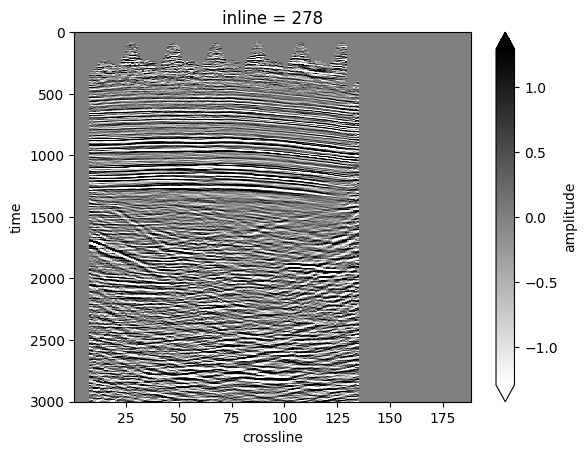

In [9]:
from mdio.builder.schemas.v1.stats import SummaryStatistics

stats = SummaryStatistics.model_validate_json(dataset["amplitude"].attrs["statsV1"])
std = ((stats.sum_squares / stats.count) - (stats.sum / stats.count) ** 2) ** 0.5

il_dataset = dataset.sel(inline=278)
il_amp = il_dataset["amplitude"].T
il_amp.plot(vmin=-2 * std, vmax=2 * std, cmap="gray_r", yincrease=False);

Let's do the same with a time slice.

We will display two-way-time at 1,000 ms.

Note that since we parse the X/Y coordinates, we can plot time slice in real world coordinates.

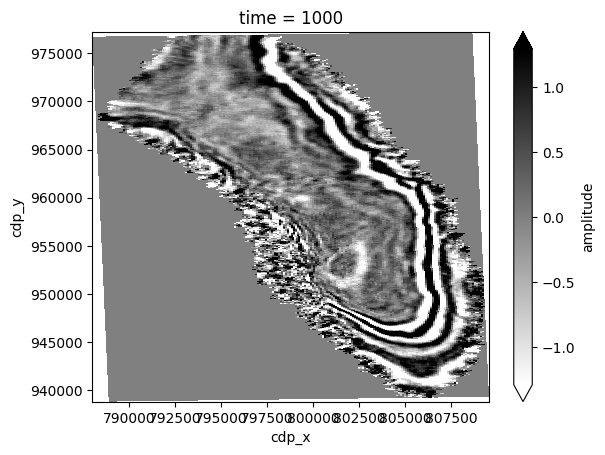

In [10]:
twt_data = dataset["amplitude"].sel(time=1000)
twt_data.plot(vmin=-2 * std, vmax=2 * std, cmap="gray_r", x="cdp_x", y="cdp_y");

We can also overlay live mask with the time slice. However, in this example, the dataset is zero-padded.

The live trace mask will always show True (yellow).

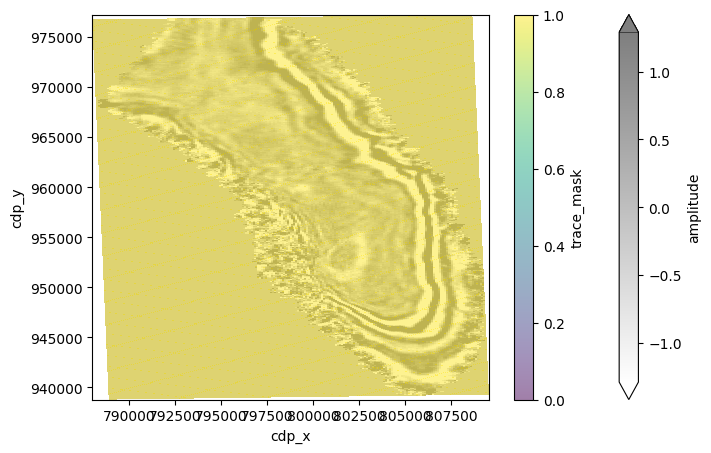

In [11]:
trace_mask = dataset.trace_mask[:]

twt_data.plot(vmin=-2 * std, vmax=2 * std, cmap="gray_r", x="cdp_x", y="cdp_y", alpha=0.5, figsize=(8, 5))
trace_mask.plot(vmin=0, vmax=1, x="cdp_x", y="cdp_y", alpha=0.5);

## Query Headers

We can query headers for the whole dataset very quickly because they are separated from the seismic wavefield.

Let's get all the headers for X and Y coordinates in this dataset.

Note that the header maps will still share the geometry/grid of the dataset!

The `compute` property fetches the lazily opened MDIO values.

In [12]:
dataset.headers["cdp_x"].compute()

<xarray.DataArray 'cdp_x' (inline: 345, crossline: 188)> Size: 519kB
array([[788937., 789047., 789157., ..., 809282., 809392., 809502.],
       [788935., 789045., 789155., ..., 809279., 809389., 809499.],
       [788932., 789042., 789152., ..., 809276., 809386., 809496.],
       ...,
       [788044., 788154., 788264., ..., 808389., 808499., 808609.],
       [788042., 788152., 788262., ..., 808386., 808496., 808606.],
       [788039., 788149., 788259., ..., 808383., 808493., 808603.]],
      shape=(345, 188))
Coordinates:
    cdp_y      (inline, crossline) float64 519kB 9.388e+05 ... 9.772e+05
    cdp_x      (inline, crossline) float64 519kB 7.889e+05 ... 8.086e+05
  * inline     (inline) int32 1kB 1 2 3 4 5 6 7 ... 339 340 341 342 343 344 345
  * crossline  (crossline) int32 752B 1 2 3 4 5 6 7 ... 183 184 185 186 187 188

In [13]:
dataset.headers["cdp_y"].compute()

<xarray.DataArray 'cdp_y' (inline: 345, crossline: 188)> Size: 519kB
array([[938846., 938848., 938851., ..., 939329., 939331., 939334.],
       [938956., 938958., 938961., ..., 939439., 939441., 939444.],
       [939066., 939068., 939071., ..., 939549., 939551., 939554.],
       ...,
       [976455., 976458., 976460., ..., 976938., 976941., 976943.],
       [976565., 976568., 976570., ..., 977048., 977051., 977053.],
       [976675., 976678., 976680., ..., 977158., 977161., 977163.]],
      shape=(345, 188))
Coordinates:
    cdp_y      (inline, crossline) float64 519kB 9.388e+05 ... 9.772e+05
    cdp_x      (inline, crossline) float64 519kB 7.889e+05 ... 8.086e+05
  * inline     (inline) int32 1kB 1 2 3 4 5 6 7 ... 339 340 341 342 343 344 345
  * crossline  (crossline) int32 752B 1 2 3 4 5 6 7 ... 183 184 185 186 187 188

As we mentioned before, we can also get specific dataset slices of headers while fetching a slice.

Let's fetch a crossline; we are still using some previous parameters.

Since the sliced dataset contains the headers as well, we can plot the headers on top of the image.

Full headers can be mapped and plotted as well, but we won't demonstrate that here.

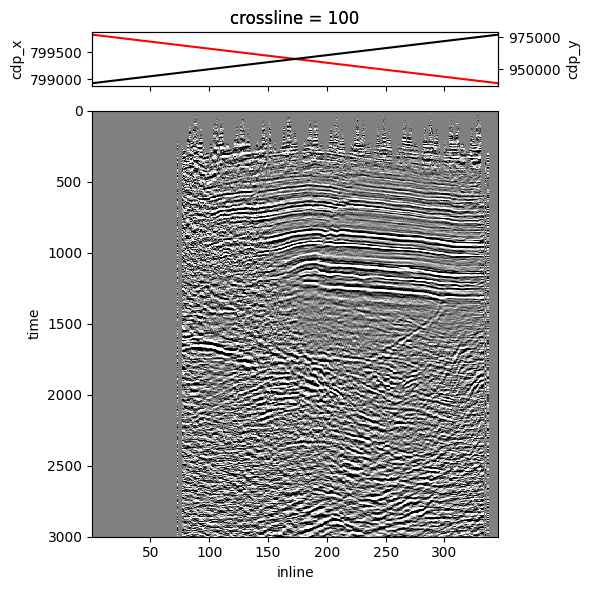

In [14]:
xl_dataset = dataset.sel(crossline=100)  # slices everything available in MDIO dataset!

cdp_x_header = xl_dataset["cdp_x"]
cdp_y_header = xl_dataset["cdp_y"]
image = xl_dataset["amplitude"].T

# Build plot from here
gs_kw = {"height_ratios": (1, 8)}
fig, (hdr_ax, img_ax) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw=gs_kw, sharex="all")
hdr_ax2 = hdr_ax.twinx()

cdp_x_header.plot(ax=hdr_ax, c="red")
cdp_y_header.plot(ax=hdr_ax2, c="black")
image.plot(ax=img_ax, vmin=-2 * std, vmax=2 * std, cmap="gray_r", yincrease=False, add_colorbar=False)
img_ax.set_title("")
hdr_ax.set_xlabel("")

plt.tight_layout()

## MDIO to SEG-Y Conversion

Finally, let's demonstrate going back to SEG-Y.

We will use the convenient `mdio_to_segy` function and write it out as a round-trip file.

The output spec can be modified if we want to write things to different byte locations, etc, but we will use the same one as before.

In [15]:
from mdio import mdio_to_segy

mdio_to_segy(
    input_path="filt_mig.mdio",
    output_path="filt_mig_roundtrip.sgy",
    segy_spec=teapot_segy_spec,
)

Merging lines: 100%|██████████| 345/345 [00:00<00:00, 2019.28it/s]


## Validate Round-Trip SEG-Y File

We can validate if the round-trip SEG-Y file is matching the original using [TGSAI/segy][segy-github].

Step by step:
* Open original file
* Open round-trip file
* Compare text headers
* Compare binary headers
* Compare 100 random headers and traces

[segy-github]: https://github.com/TGSAI/segy

In [16]:
import numpy as np
from segy import SegyFile

original_segy = SegyFile(input_url)
roundtrip_segy = SegyFile("filt_mig_roundtrip.sgy")

# Compare text header
assert original_segy.text_header == roundtrip_segy.text_header

# Compare bin header
assert original_segy.binary_header == roundtrip_segy.binary_header

# Compare 100 random trace headers and traces
rng = np.random.default_rng()
rand_indices = rng.integers(low=0, high=original_segy.num_traces, size=100)
for idx in rand_indices:
    np.testing.assert_equal(original_segy.trace[idx], roundtrip_segy.trace[idx])

print("Files identical!")

Files identical!
